# Introduction to fractal dimension 
In this notebook we will discuss the concept of parametrization of the surface at different scales in a deeper manner. We introduce the fractal dimension.

In [ ]:
!pip install Shapely
!pip install geopandas

In [95]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import LineString,Point,MultiPoint,LinearRing
from matplotlib2tikz import save as tikz_save
import geopandas

In [3]:
plt.rcParams["figure.figsize"] = (18,3)

We create a random profile for initial testing:

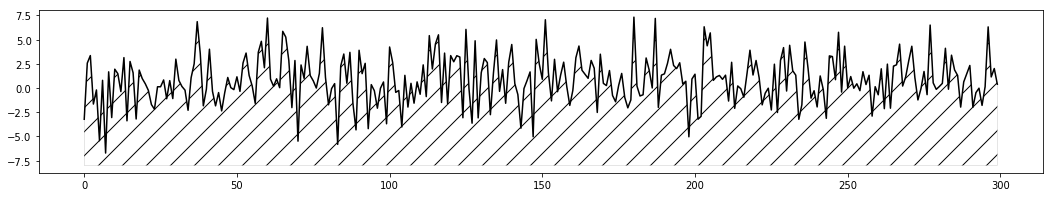

In [4]:
mean, sigma = 1, 2.5 # mean and standard deviation
points = 300
xp = range(points)
yp = np.random.normal(mean, sigma, points)
plt.plot(xp,yp,'k-')
plt.fill_between(xp, -8, yp, facecolor="none", hatch="/", edgecolor="k", linewidth=0.1)
plt.show()

Now we define a `LineString` data structure for rappresenting the profile. This is equivalent to a polyline or a polygonal chain in geometry.

In [5]:
list_of_point = list(zip(xp,yp))
profile = LineString(list_of_point)

We define a function for finding the intersection of the circle with the LineString.

In [6]:
sampling_radius = 5
def find_inter(p,sampling_radius,profile=profile):
    # Create a circle c with a radius = sampling radius.
    c = p.buffer(sampling_radius).boundary
    # Find intersection of the circle with the profile.
    i = c.intersection(profile)
    #print i
    return i


In [7]:
p1 = find_inter(Point(list(list_of_point)[0]),sampling_radius=sampling_radius)
print(p1)

MULTIPOINT (0.8481175307111607 1.691881761561385, 2.444628831600808 1.126140975133288, 3.985460483271072 -0.2213181318412077, 4.010460168089129 -0.2550263047047222, 4.823992071517826 -4.525500212301123)


In [9]:
%qtconsole

In [23]:
go = True
count = 0
# we define the starting point
point = Point(list_of_point[0])
intersections  = []
points_found = []
points_found.append(point)
for i in range(40):
    pointx = point.coords[0][0]
    # we find the next point (the intersection)
    point = find_inter(point,sampling_radius,profile=profile)
    count +=1
    intersections.append(point)
    # if there is more than one interesection we will have a multi point
    if type(point) is MultiPoint:
        listx = np.array([i.coords[0][0] for i in point])
        # find the smallest value after the starting point
        value = listx[listx > pointx].min()
        # This is true for profile following a straight line because they
        # ordered  
        itemindex = np.where(listx==value)
        point = point[itemindex[0][0]]
        points_found.append(point)
    else:
        points_found.append(point)

In [24]:
multi = intersections[3]
multi[0].coords[0]

(6.200112446144149, -0.29572275070196447)

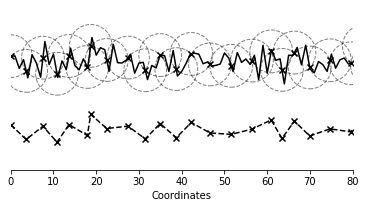

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)
maxyp, minyp = max(yp),min(yp)
ax.plot(xp,yp,'k-')
for inter in intersections:
    # if there is more than one intersection
    if type(inter) is MultiPoint:
        for j in inter:
            x,y = j.coords[0]
            # we can plot all the intersections found
            #ax.scatter(x,y,color='k',marker='x',alpha=0.5)
    else:
        x,y = inter.coords[0]
        #ax.scatter(x,y,color='b',marker='x')
for pt in points_found:
    x,y = pt.coords[0]
    circle1 = plt.Circle((x, y), sampling_radius, color='k', fill=False,linestyle='--',alpha=0.5)
    ax.add_artist(circle1)

xn,yn = np.array([pt.coords[0] for pt in points_found]).T
ax.scatter(xn,yn,color='k',marker='x')
maxyn, minyn = max(yn),min(yn)
#ax.plot(xn,yn,linestyle='--',color='g')
ax.set_aspect('equal')
shifteyn = yn - maxyn - abs(minyp) - sampling_radius*1.2
ax.plot(xn,shifteyn,linestyle='--',color='k')
ax.scatter(xn,shifteyn,color='k',marker='x')
ax.set_ylim(min(shifteyn)+min(shifteyn)*0.2,maxyp+sampling_radius*1.2)
ax.set_xlim(0,80)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_xlabel("Coordinates")
#fig.savefig("fig3.pgf")
#tikz_save("test3.tex")
# unit vector ratio*=1 1 1,
plt.show()



We have try now to deal with more complex shapes. In particular when we have more than one point for coordinate.
This data has been extracted from https://www.ngdc.noaa.gov/mgg/shorelines/data/gshhg/latest/gshhg-shp-2.3.7.zip (last modified 2018-03-02 18:42). GSHHG is released under the GNU Lesser General Public license, and is developed and maintained by Dr. Paul Wessel, SOEST, University of Hawai, and Dr. Walter H. F. Smith, NOAA Laboratory for Satellite Altimetry. To reproduce the experiment by Richardson we extracted the coast of Great Britain and saved in a .shp file.

In [44]:
gbr = geopandas.read_file(r'.\Data\ID_15_GSHHS_F_L1.shp')
len(list(gbr.geometry.iloc[0].coords))

49153

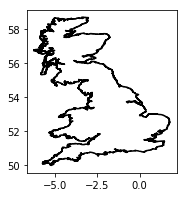

In [46]:
gbr.plot(color='k')

In [120]:
gbr_points = np.array(list(gbr.geometry.iloc[0].coords))

The problem with this shape is that we might have some intersection closer to the origin point which are actually very far along the coast. So we have to select the first intersection following the coastline.

In [131]:
go = True
count = 0
# we define the starting point
x,y = gbr_points[0]
point = Point(x,y)
intersections  = []
points_found = []
points_found.append(point)
sampling_radius = 3
multipoint = None
print(type(point))
for i in range(40):
    oldpoint = point.coords[0] # this is the center of the circle
    # we find the next point (the intersection) with the geometry of the shapfile
    point = find_inter(point,sampling_radius,profile=gbr.geometry.iloc[0]) 
    count +=1
    intersections.append(point)
    # if there is more than one interesection we will have a multi point
    if type(point) is MultiPoint:
        multipoint = point
        indexes = [idx for idx,elem in enumerate(haystack) if elem in needles ]

        points_found.append(point)
    else:
        points_found.append(point)

<class 'shapely.geometry.point.Point'>


NotImplementedError: Multi-part geometries do not provide a coordinate sequence

# Rolling circle envelope 
The method used by Richardson, maybe substit

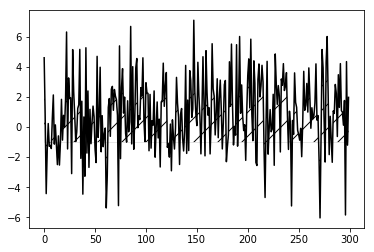

In [11]:
mean, sigma = 1, 2.5 # mean and standard deviation
points = 300
xp = range(points)
yp = np.random.normal(mean, sigma, points)
plt.plot(xp,yp,'k-')
plt.fill_between(xp, -1, yp, facecolor="none", hatch="/", edgecolor="k", linewidth=0.1)
plt.show()

In [12]:
list_of_point = zip(xp,yp)
profile = LineString(list_of_point)

In [13]:
circle_radius = 2
max_value = max(yp)
# The circle will never encounter value above the max value of the profile
starting_ycoord = max_value + circle_radius
min_ycord = min(yp) + circle_radius
# TODO: we could optimize the range over windows of the size of the diameters.
points = []
traiectory = []
for step in range(40):
    xcoor = list_of_point[step][0]
    max_value = list_of_point[step][1] + circle_radius*0.9
    for y in np.linspace(starting_ycoord,max_value):
        p = Point(xcoor,y)
        # Create a circle c with a radius = sampling radius.
        c = p.buffer(circle_radius).boundary
        # Find intersection of the circle with the profile.
        traiectory.append((xcoor,y))
        if c.intersects(profile):
            points.append((xcoor,y))
            break

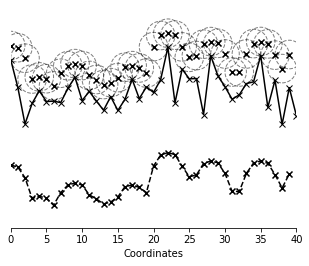

In [14]:

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
maxyp, minyp = max(yp),min(yp)
ax2.plot(xp,yp,'k',marker = 'x')

for pt in points:
    circle1 = plt.Circle(pt, circle_radius, color='k', fill=False,linestyle='--',alpha=0.5)
    ax2.add_artist(circle1)
#traiectory
#xt,yt = np.array(traiectory).T
#ax2.scatter(xt,yt,color='g',marker = 'x',alpha=0.4)
    
xn,yn = np.array(points).T
ax2.scatter(xn,yn,color='k',marker='x')
maxyn, minyn = max(yn),min(yn)
#ax.plot(xn,yn,linestyle='--',color='g')
ax2.set_aspect('equal')
shifteyn = yn - maxyn - abs(minyp) - circle_radius*1.2
ax2.plot(xn,shifteyn,linestyle='--',color='k')
ax2.scatter(xn,shifteyn,color='k',marker='x')
ax2.set_ylim(min(shifteyn)+min(shifteyn)*0.2,maxyp+circle_radius*2.2)
ax2.set_xlim(0,40)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
ax2.set_xlabel("Coordinates")
#fig.savefig("fig3.pgf")
#tikz_save("test3.tex")
# unit vector ratio*=1 1 1,
plt.show()


In [7]:
%qtconsole

In [449]:
xpt = [-2,1,2,2.5,4,1,-1,2,4,5,6]
ypt = [-2,1,1,0,1,2,2,3,4,4,4]
sampling_radius=1.5
list_of_point = list(zip(xpt,ypt))
p = Point(2,1)
profile = LineString(list_of_point)
c = p.buffer(sampling_radius).boundary
# Find intersection of the circle with the profile.
#points = c.intersection(profile)
points = profile.intersection(c)

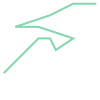

In [450]:
profile

In [451]:
points = find_inter(Point(2,1),sampling_radius=1.5,profile=profile)

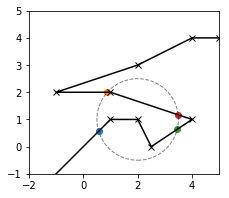

In [455]:
fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
ax3.set_xlim(-2,5)
ax3.set_ylim(-1,5)
maxyp, minyp = max(ypt),min(ypt)
ax3.plot(xpt,ypt,'k',marker = 'x')
ax3.set_aspect('equal')
circle_radius = 1.5
circle1 = plt.Circle((2,1), sampling_radius, color='k', fill=False,linestyle='--',alpha=0.5)
for i in np.array(points):
    ax3.scatter(i[0],i[1])
#ax3.annotate(-1,0,1,1)
ax3.add_artist(circle1)

In [456]:
np.array(points)

array([[0.56458619, 0.56458619],
       [0.88436065, 2.        ],
       [3.45316212, 0.63544141],
       [3.48933636, 1.17022121]])

In [457]:
for i in profile.coords:
    print(i)

(-2.0, -2.0)
(1.0, 1.0)
(2.0, 1.0)
(2.5, 0.0)
(4.0, 1.0)
(1.0, 2.0)
(-1.0, 2.0)
(2.0, 3.0)
(4.0, 4.0)
(5.0, 4.0)
(6.0, 4.0)


In [459]:
from shapely.ops import split
points_to_split = MultiPoint([Point(x,y) for x,y in profile.coords[1:]])
splitted = split(profile,points_to_split)

In [460]:
def tuple_are_different(tuplea,tupleb):
    if np.isclose(tuplea[0],tupleb[0],atol=0.1) and np.isclose(tuplea[1],tupleb[1],atol=0.1):
        return False
    else:
        return True

In [461]:
def right_direction(previuscoor,intersection,segment):
    xs,xs  = segment.coords[0]
    xi,yi = intersection.coords[0]
    xp, yp = previouscoor
    dist_inter = ((xs-xi)**2 + (ys-yi)**2 )**0.5
    dist_old = ((xs-xp)**2 + (ys-yp)**2)**0.5
    if dist_inter > dist_old:
        return True
    else:
        return False

In [469]:
from math import isclose
currentpoint = Point(-2.0, -2.0)
intersections_list = [currentpoint.coords[0],currentpoint.coords[0]]
c = currentpoint.buffer(sampling_radius).boundary
index = 0
inline = False # True when the previous point was on the same segment
for i in range(40):
    print(index)
    intersections = splitted[index].intersection(c)
    print(type(intersections))
    if (type(intersections) is Point):
        if inline:
            print('Collinear')
            xs,ys  = splitted[index].coords[0]
            print(xs,ys)
            xi,yi = intersections.coords[0]
            xp, yp = intersections_list[-1]
            dist_inter = ((xs-xi)**2 + (ys-yi)**2 )**0.5
            dist_old = ((xs-xp)**2 + (ys-yp)**2)**0.5
            if dist_inter > dist_old:
                currentpoint = intersections
                c = currentpoint.buffer(sampling_radius).boundary
                intersections_list.append(intersections.coords[0])
                inline = True
            else:
                index +=1
                inline = False
        else:
            print('New point')
            currentpoint = intersections
            c = currentpoint.buffer(sampling_radius).boundary
            intersections_list.append(intersections.coords[0])
            inline = True
    else:
        print('New segment')
        # we pass to the next segment if the current circle
        # do not intersect with it.
        # Rememeber more than one circles could intersect with
        # a segment excpecially if it's very long
        index +=1
        inline = False

0
<class 'shapely.geometry.point.Point'>
New point
0
<class 'shapely.geometry.point.Point'>
Collinear
-2.0 -2.0
0
<class 'shapely.geometry.point.Point'>
Collinear
-2.0 -2.0
1
<class 'shapely.geometry.point.Point'>
New point
1
<class 'shapely.geometry.collection.GeometryCollection'>
New segment
2
<class 'shapely.geometry.point.Point'>
New point
2
<class 'shapely.geometry.collection.GeometryCollection'>
New segment
3
<class 'shapely.geometry.point.Point'>
New point
3
<class 'shapely.geometry.point.Point'>
Collinear
2.5 0.0
4
<class 'shapely.geometry.point.Point'>
New point
4
<class 'shapely.geometry.point.Point'>
Collinear
4.0 1.0
5
<class 'shapely.geometry.point.Point'>
New point
5
<class 'shapely.geometry.point.Point'>
Collinear
1.0 2.0
5
<class 'shapely.geometry.point.Point'>
Collinear
1.0 2.0
6
<class 'shapely.geometry.point.Point'>
New point
6
<class 'shapely.geometry.point.Point'>
Collinear
-1.0 2.0
7
<class 'shapely.geometry.point.Point'>
New point
7
<class 'shapely.geometry.point

IndexError: index out of range

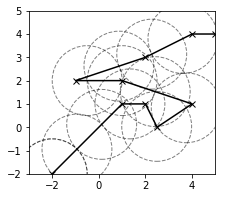

In [477]:
fig4 = plt.figure()
ax4 = fig4.add_subplot(111)
ax4.set_xlim(-3,5)
ax4.set_ylim(-2,5)
ax4.plot(xpt,ypt,'k',marker = 'x')
ax4.set_aspect('equal')
for x,y in intersections_list[:13]:
    circle1 = plt.Circle((x,y), sampling_radius, color='k', fill=False,linestyle='--',alpha=0.5)
    ax4.add_artist(circle1)

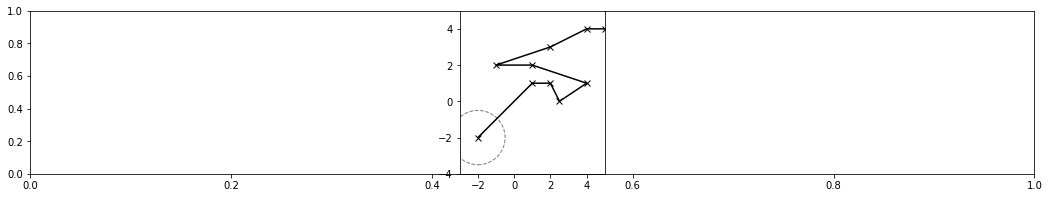

In [430]:
from matplotlib import animation, rc
from IPython.display import HTML

fig4,ax4 = plt.subplots()
ax4 = fig4.add_subplot(111)
ax4.set_xlim(-3,5)
ax4.set_ylim(-4,5)
ax4.plot(xp,yp,'k',marker = 'x')
ax4.set_aspect('equal')

for i in np.array(points):
    ax3.scatter(i[0],i[1])
#for x,y in intersections_list:
#    circle1 = plt.Circle((x,y), sampling_radius, color='k', fill=False,linestyle='--',alpha=0.5)
#ax3.annotate(-1,0,1,1)
#    ax4.add_artist(circle1)
def animate(i):
    x,y = intersections_list[i]
    circle1 = plt.Circle((x,y), sampling_radius, color='k', fill=False,linestyle='--',alpha=0.5)
    ax4.add_artist(circle1)
    return circle1,
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig4, animate,
                               frames=100, interval=20, blit=True)

In [431]:
HTML(anim.to_html5_video())

RuntimeError: Requested MovieWriter (ffmpeg) not available

In [432]:
for i in intersections_list: print (i)

(-2.0, -2.0)
(-2.0, -2.0)
(-0.9393398282201789, -0.939339828220179)
(0.121320343559642, 0.12132034355964208)
(1.334909965033549, 1.0)
(2.482418747905518, 0.03516250418896415)
(3.7505086911426178, 0.8336724607617452)
(2.420827160067956, 1.5263909466440146)
(3.8424777079198686, 1.052507430693377)


In [309]:
x,y

(-0.9393398282201789, -0.939339828220179)

In [ ]:
from math import isclose
currentpoint = Point(-2.0, -2.0)
intersections_list = [currentpoint.coords[0],currentpoint.coords[0]]
c = currentpoint.buffer(sampling_radius).boundary
index = 0
for i in range(40):
    print(index)
    intersections = splitted[index].intersection(c)
    print(type(intersections))
    current_coord = intersections.coords[0]
    opposite_coord = intersections_list[-2]
    if (type(intersections) is Point) and tuple_are_different(current_coord,opposite_coord):
            currentpoint = intersections
            c = currentpoint.buffer(sampling_radius).boundary
            intersections_list.append(intersections.coords[0])
    else:
        # we pass to the next segment if the current circle
        # do not intersect with it.
        # Rememeber more than one circles could intersect with
        # a segment excpecially if it's very long
        index +=1
        inline = False